<font size="+3"><strong>3.5. Air Quality in Dar es Salaam 🇹🇿</strong></font>

In [205]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [206]:
# Import libraries here

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from IPython.display import VimeoVideo
from pymongo import MongoClient
from pprint import PrettyPrinter 
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Connect

<div style="padding: 1em; border: 1px solid #f0ad4e; border-left: 6px solid #f0ad4e; background-color: #fcf8e3; color: #8a6d3b; border-radius: 4px;">

<strong>🛠️ Instruction:</strong> Locate the IP address of the machine running MongoDB and assign it to the variable <code>host</code>. Make sure to use a <strong>string</strong> (i.e., wrap the IP in quotes).<br><br>

<strong>⚠️ Note:</strong> The IP address is <strong>dynamic</strong> — it may change every time you start the lab. Always check the current IP before proceeding.

</div>

<img src="../images/mongo_ip.png" alt="MongoDB" width="600"/>


In [207]:
host = "..."

**Task 3.5.1**

In [208]:
client =MongoClient(host="192.42.98.2",port=27017)
db = client["air-quality"]
dar = db["dar-es-salaam"]

## Explore

**Task 3.5.2**

In [209]:
pp = PrettyPrinter(indent=2)

In [210]:
#doc=dar.find_one({})
sites = dar.distinct("metadata.site")
sites
#pp.pprint(doc)

[11, 23]

**Task 3.5.3**

In [211]:
result = dar.aggregate(
    [
        {"$group":{"_id":"$metadata.site","count":{"$count":{}}}}
    ]
    
)
#pp.pprint(list(result))

readings_per_site = list(result)
readings_per_site

[{'_id': 11, 'count': 173242}, {'_id': 23, 'count': 60020}]

## Import

**Task 3.5.4**

In [212]:
result = dar.find(
    {"metadata.site": 11, "metadata.measurement": "P2"},
    projection={"P2": 1, "timestamp": 1, "_id": 0}
)
pp.pprint(result.next())

{'P2': 9.27, 'timestamp': datetime.datetime(2018, 1, 1, 0, 0, 4, 53000)}


In [213]:
def wrangle(collection):
    results = collection.find(
        {"metadata.site": 11, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )
    
    df = pd.DataFrame(list(results)).set_index("timestamp")  # Create df first
    
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")  # Then localize timezone
    
    df = df[df["P2"] < 100]  # Remove outliers
    
    y = df["P2"].resample("1H").mean().fillna(method="ffill")  # Resample and forward-fill
    
    return y


Use your `wrangle` function to query the `dar` collection and return your cleaned results.

In [214]:
y = wrangle(dar)
print(type(y))
y

<class 'pandas.core.series.Series'>


timestamp
2018-01-01 03:00:00+03:00     9.456327
2018-01-01 04:00:00+03:00     9.400833
2018-01-01 05:00:00+03:00     9.331458
2018-01-01 06:00:00+03:00     9.528776
2018-01-01 07:00:00+03:00     8.861250
                               ...    
2018-03-31 22:00:00+03:00     8.460000
2018-03-31 23:00:00+03:00     5.725000
2018-04-01 00:00:00+03:00     8.089167
2018-04-01 01:00:00+03:00    29.476250
2018-04-01 02:00:00+03:00    16.780417
Freq: H, Name: P2, Length: 2160, dtype: float64

## Explore Some More

**Task 3.5.5**

Text(0.5, 1.0, 'Dar es Salaam PM2.5 Levels')

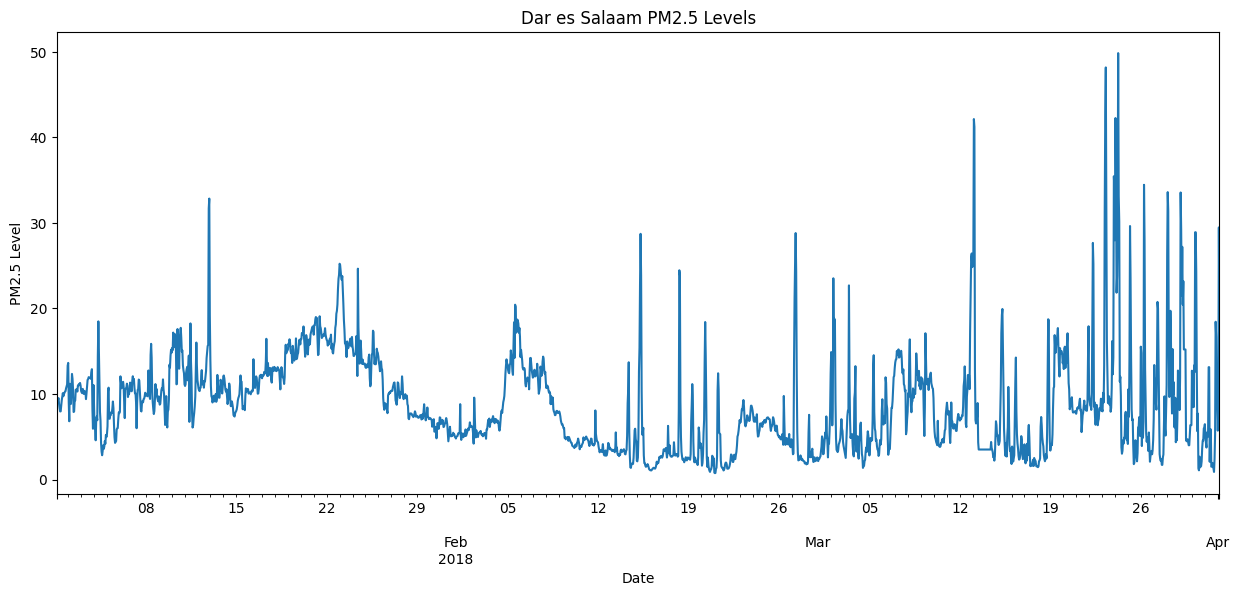

In [215]:
fig, ax = plt.subplots(figsize=(15, 6))
y.plot()
plt.xlabel("Date")
plt.ylabel("PM2.5 Level")
plt.title("Dar es Salaam PM2.5 Levels")
# use ax=ax in your plot


**Task 3.5.6**

Text(0.5, 1.0, 'Dar es Salaam PM2.5 Levels, 7-Day Rolling Average')

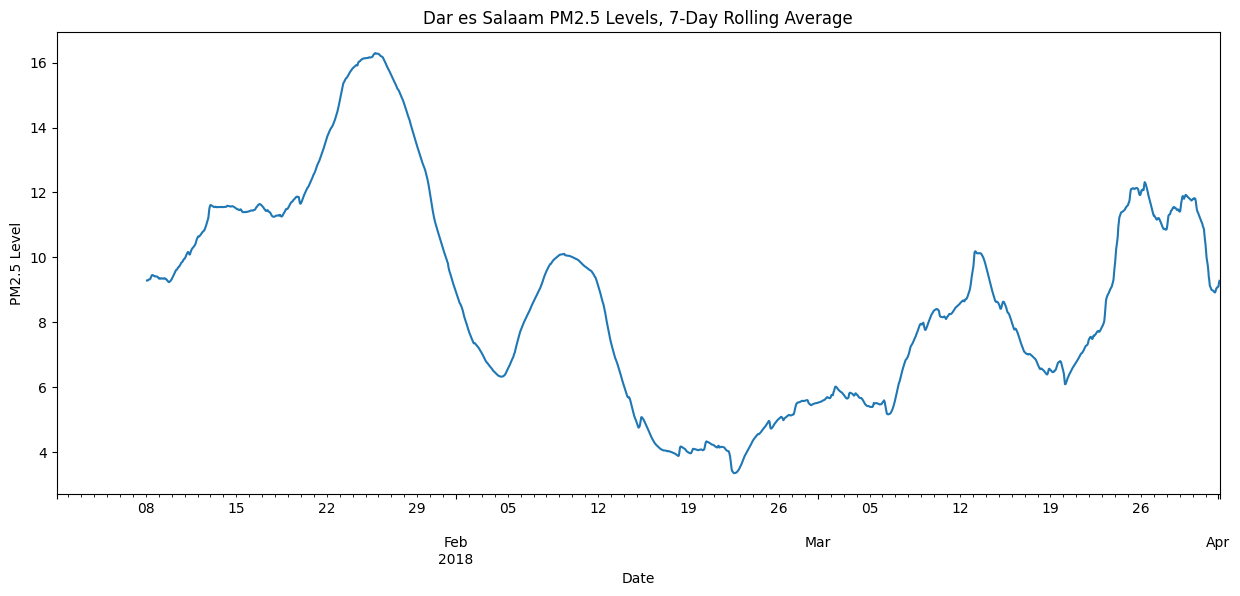

In [216]:

fig, ax = plt.subplots(figsize=(15, 6))
y.rolling(window=168).mean().plot()
plt.xlabel("Date")
plt.ylabel("PM2.5 Level")
plt.title("Dar es Salaam PM2.5 Levels, 7-Day Rolling Average")

# use ax=ax in your plot


**Task 3.5.7**

Text(0.5, 1.0, 'Dar es Salaam PM2.5 Readings, ACF')

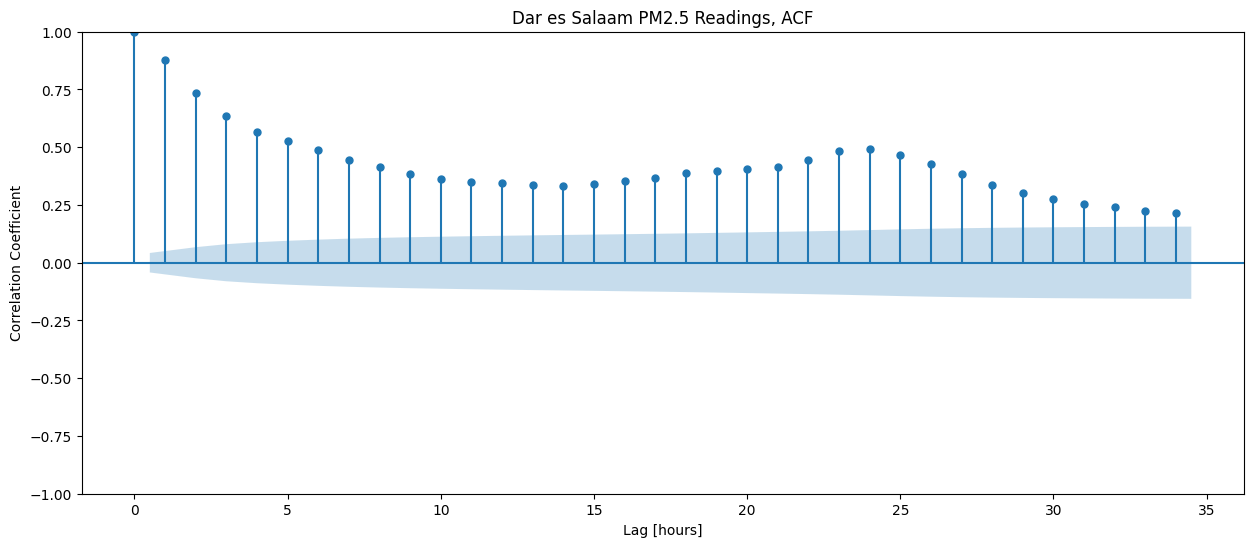

In [217]:

fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, ACF")
# use ax=ax in your plot


**Task 3.5.8**

Text(0.5, 1.0, 'Dar es Salaam PM2.5 Readings, PACF')

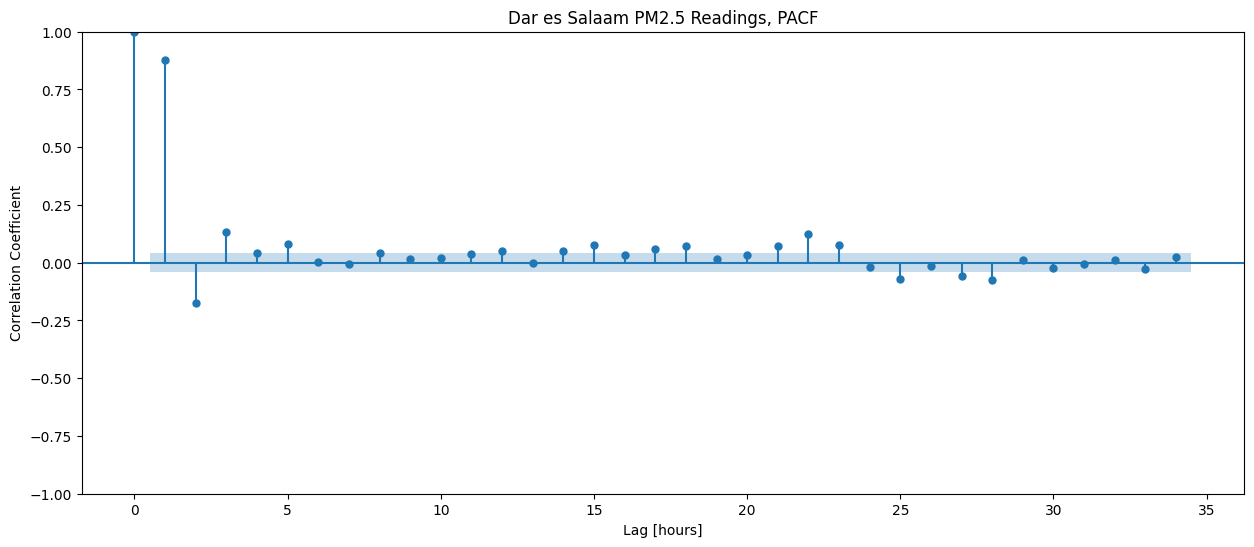

In [218]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, PACF")
# Use ax=ax in your plot


## Split

**Task 3.5.9**

In [219]:
 int(len(y)*0.90)
#len(y)

1944

In [220]:
cutoff_test =int(len(y)*0.90)
y_train = y.iloc[:cutoff_test]
y_test =y.iloc[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1944,)
y_test shape: (216,)


In [221]:
len(y_train)+len(y_test)==len(y)

True

# Build Model

## Baseline

**Task 3.5.10**

In [222]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 8.57142319061077
Baseline MAE: 4.053101181299159


## Iterate

**Task 3.5.11**

<div class="alert alert-block alert-info">
    <p><b>Tip:</b> In this task, you'll need to combine the model you learned about in <b>Task 3.3.8</b> with the hyperparameter tuning technique you learned in <b>Task 3.4.9</b>.</p>
</div>

In [223]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
# Create range to test different lags
p_params = range(1, 31)

# Create empty list to hold mean absolute error scores
maes = []

# Iterate through all values of p in `p_params`
for p in p_params:
    # Build model
    model =  AutoReg(y_train,lags=p).fit()

    # Make predictions on training data, dropping null values caused by lag
    y_pred = model.predict().dropna()

    # Calculate mean absolute error for training data vs predictions
    mae = mean_absolute_error(y_train.iloc[p:], y_pred)

    # Append `mae` to list `maes`
    maes.append(mae)

# Put list `maes` into Series with index `p_params`
mae_series = pd.Series(maes, name="mae", index=p_params)

# Inspect head of Series
mae_series.head(30)

1     1.059376
2     1.045182
3     1.032489
4     1.032147
5     1.031022
6     1.026948
7     1.023510
8     1.022944
9     1.022321
10    1.022058
11    1.018001
12    1.018568
13    1.019006
14    1.018080
15    1.018818
16    1.021036
17    1.021398
18    1.021820
19    1.020472
20    1.019727
21    1.017981
22    1.017824
23    1.014569
24    1.013427
25    1.010657
26    1.010285
27    1.010619
28    1.010287
29    1.012046
30    1.016535
Name: mae, dtype: float64

**Task 3.5.12**

In [224]:
best_p = mae_series.idxmin()
best_model =AutoReg(y_train,lags=best_p).fit()

**Task 3.5.13**

In [225]:
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

timestamp
2018-01-02 05:00:00+03:00   -0.412913
2018-01-02 06:00:00+03:00    1.484934
2018-01-02 07:00:00+03:00    1.672359
2018-01-02 08:00:00+03:00   -0.368030
2018-01-02 09:00:00+03:00   -0.536868
Freq: H, Name: residuals, dtype: float64

<div class="alert alert-info" role="alert">
  <strong>Slight Code Change</strong>

In the following task, you'll notice a small change in how plots are created compared to what you saw in the lessons.
While the lessons use the global matplotlib method like <code>plt.plot(...)</code>, in this task, you are expected to use the object-oriented (OOP) API instead.
This means creating your plots using <code>fig, ax = plt.subplots()</code> and then calling plotting methods on the <code>ax</code> object, such as <code>ax.plot(...)</code>, <code>ax.hist(...)</code>, or <code>ax.scatter(...)</code>.

If you're using pandas’ or seaborn’s built-in plotting methods (like <code>df.plot()</code> or <code>sns.lineplot()</code>), make sure to pass the <code>ax=ax</code> argument so that the plot is rendered on the correct axes.

This approach is considered best practice and will be used consistently across all graded tasks that involve matplotlib.
</div>


**Task 3.5.14**

Text(0.5, 1.0, 'Best Model, Training Residuals')

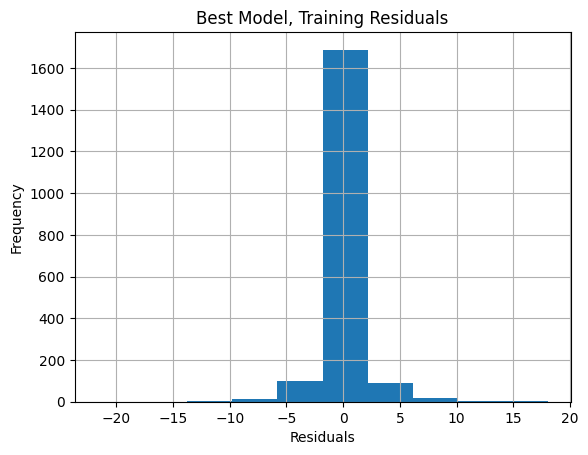

In [226]:
# Plot histogram of residuals
fig, ax = plt.subplots()
y_train_resid.hist()
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Best Model, Training Residuals")

**Task 3.5.15**

Text(0.5, 1.0, 'Dar es Salaam, Training Residuals ACF')

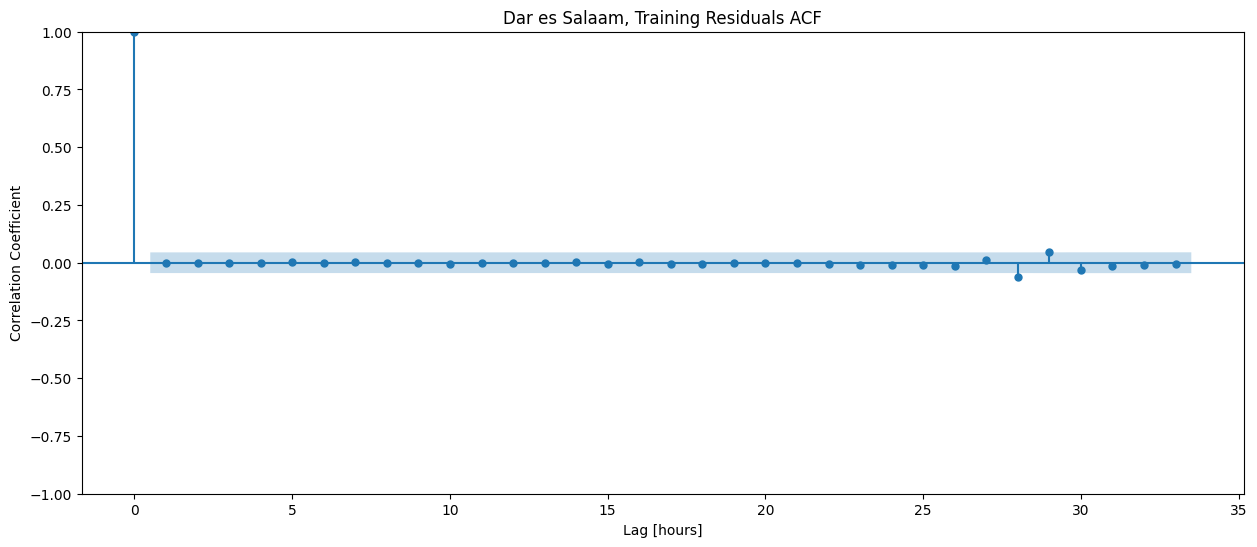

In [227]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam, Training Residuals ACF")
# Use ax=ax in your plot


## Evaluate

**Task 3.5.16**

In [228]:


# Initialize empty Series
y_pred_wfv = pd.Series(dtype=float)

# Correct: copy the y_train data
history = y_train.copy()

# Walk-forward validation loop
for i in range(len(y_test)):
    model = AutoReg(history, lags=best_p, old_names=False).fit()
   
    next_pred=model.forecast()
    # Append the prediction
    y_pred_wfv = y_pred_wfv.append(next_pred)
    
    # Append the actual value from y_test to history for next step
    history = history.append(pd.Series(y_test.iloc[i], index=next_pred.index))

# Finalize prediction series
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"

# Show predictions
y_pred_wfv


timestamp
2018-03-23 03:00:00+03:00    10.414744
2018-03-23 04:00:00+03:00     8.269589
2018-03-23 05:00:00+03:00    15.178677
2018-03-23 06:00:00+03:00    33.475398
2018-03-23 07:00:00+03:00    39.571363
                               ...    
2018-03-31 22:00:00+03:00     6.939370
2018-03-31 23:00:00+03:00     8.114680
2018-04-01 00:00:00+03:00     5.710798
2018-04-01 01:00:00+03:00     9.133960
2018-04-01 02:00:00+03:00    28.946615
Freq: H, Name: prediction, Length: 216, dtype: float64

**Task 3.5.17**

In [229]:
# Enter y_pred_wfv at ... (Ellipsis) to see the test mean absolute error

test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 3.97


# Communicate Results

**Task 3.5.18**

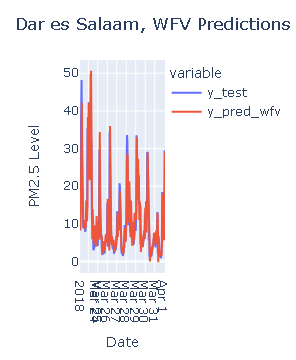

In [203]:
df_pred_test =pd.DataFrame({
    "y_test":y_test,"y_pred_wfv":y_pred_wfv
})
fig = px.line(df_pred_test, labels={"value": "PM2.5 Level"})
fig.update_layout(
    title="Dar es Salaam, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
    
)
fig.update_xaxes(dtick="1D")
fig.show()

---
Copyright 2024 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
